In [57]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

In [58]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=1      # which GPU to use
plot=True # Plot Intermediate results
sigma=10   # Initial model smoothness 
gpu_ids=[0,1]

# Inversion parameters
num_batches = 30
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 25
dx = 15
nt = 1000
dt = 0.001
num_shots = 6
num_receivers_per_shot = 70

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

In [59]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
import torch.nn as nn
from scipy.io import savemat
from skimage.transform import resize

In [60]:
def plotVel(starting):
    
    #create figure
    fig = plt.figure(figsize=(15,7))
    
    rows = 5
    columns = 5
    
    filename=vel = np.load('/disk/student/adhara/OpenFWI/FlatFaultsupervised/FlatFault/vel4_1_2.npy')
    print("min of dataset :", np.min(filename))
    print("max of dataset :", np.max(filename))
    for i in range(25):
        fig.add_subplot(rows,columns,i+1)
        kk=starting+i

        mat=filename[starting+i,0,:,:]
        #mat_resize=resize(mat, (101,101))
        #mat_smooth=scipy.ndimage.gaussian_filter(mat,5)
        minval = np.min(mat)
        #mat[np.arange(len(mat)), mat.argmin(axis=1)] = 2000
        #print(np.min(mat))
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(mat)
        plt.axis('off')
        plt.tight_layout()

min of dataset : 3000.0
max of dataset : 6000.0


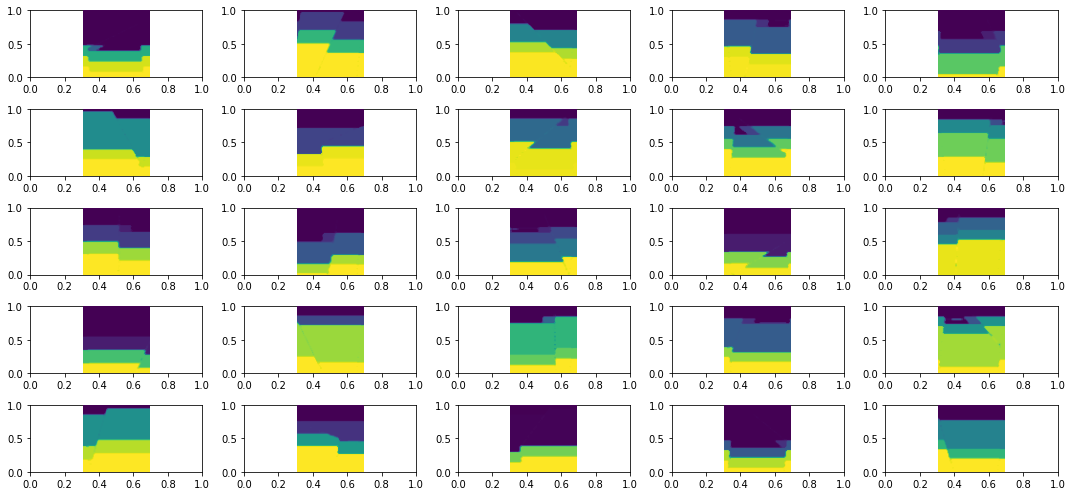

In [61]:
plotVel(1)

In [62]:
os.system('nvidia-smi')

0

min of dataset : 3000.0
max of dataset : 6000.0


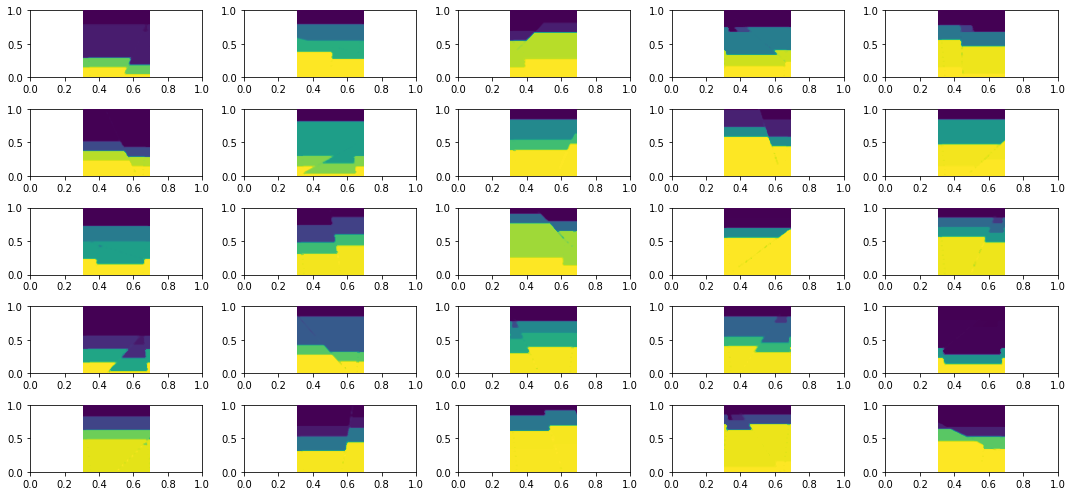

In [63]:
plotVel(100)

In [64]:
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/georec_train/')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/georec_train/')

0

In [65]:
#plot=True
# Load the true model
min1 = []
max1 = []
filename=vel = np.load('/disk/student/adhara/OpenFWI/FlatFaultsupervised/FlatFault/vel4_1_2.npy')
for kk in range(1,500):
    #kk=2
    #filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/vmodel_train/vmodel'+str(kk)+'.mat'
    mat=filename[kk,0,:,:]
    mat[(mat==np.min(mat))] = 3000
    mat[(mat==np.max(mat))] = 6000
    #mat=resize(mat,(101,101))
    #mat=mat[:-1,:-1]
    #mat = np.loadtxt('marmhard2.dat')
    #mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
    #RB Get model size
    ny = np.size(mat,1);
    nz = np.size(mat,0);
    #RB compute true model mean value and width for future model normalization
    max1=np.max(mat)
    min1=np.min(mat)
    med=(max1+min1)/2.
    wid=(max1-min1)/2.

    print('vmin=',min1,'vmax=',max1,'vmed=',med,'vwidth=',wid)
    torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
    GPU_string='cuda:'+str(GPU)
    device = torch.device(GPU_string)
    num_dims = 2
    #num_shots = 32
    num_sources_per_shot = 1
    #num_receivers_per_shot = 200

    #RB source_spacing = 25.0
    #RB receiver_spacing = 10.0
    source_spacing = ny * dx / num_shots
    receiver_spacing = ny * dx / num_receivers_per_shot
    print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
    print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
          'ds=',source_spacing,'dr=',receiver_spacing)
    
    # Create arrays containing the source and receiver locations
    # x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
    # x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
    x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
    #x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
    x_s[:,0,1] = torch.linspace(0,(ny-1)*dx,num_shots)
    #x_s[:, 0, 0] = 100. #RB Set source depth

    x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
    x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
    x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

    #RB Shuffle shot coordinates
    ###idx = torch.randperm(num_shots)
    ###x_s = x_s.view(-1,2)[idx].view(x_s.size())

    #RB Set Receiver depth
    #x_r[0, :, 0] = 100.
    #x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

    # Create true source amplitudes [nt, num_shots, num_sources_per_shot]
    # I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
    # can use whatever Tensor you want as the source amplitude.
    source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                              .reshape(-1, 1, 1)
                              .repeat(1, num_shots, num_sources_per_shot))
    
    model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
    prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
    receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                    x_s.to(device),
                                    x_r.to(device), dt).cpu()
    
    vel=np.squeeze(mat)
    seis=np.squeeze(receiver_amplitudes_all.cpu().detach().numpy())
    seis = seis.swapaxes(1,2)
    mdic = {"Rec":seis}
    
    print(np.shape(seis))
    file1 = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/georec_train/georec'+str(kk)+'.mat','wb')
    savemat(file1, mdic)
    file1.close()
    #file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainA/'+str(kk)+'.npy','wb')
    #np.save(file1,seis)
    #file1.close()
    
    min1 = np.append(min1,np.min(vel))
    max1 = np.append(max1,np.max(vel))

vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs

vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs

vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs

vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs

(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25

vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs

vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs

(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25

(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25
shots= 6 recs/shot= 70 ds= 175.0 dr= 15.0
(1000, 70, 6)
vmin= 3000.0 vmax= 6000.0 vmed= 4500.0 vwidth= 1500.0
ny= 70 nz= 70 nt= 1000 dx= 15 freq= 25

In [67]:
x_s

tensor([[[   0.,    0.]],

        [[   0.,  207.]],

        [[   0.,  414.]],

        [[   0.,  621.]],

        [[   0.,  828.]],

        [[   0., 1035.]]])

In [68]:
ny*dx

1050

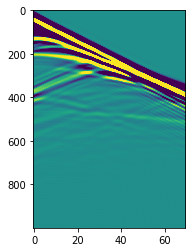

In [69]:
#fig = plt.figure()
#ax = fig.add_subplot(5,1,1)
plt.imshow(seis[:,:,0],aspect=0.1,vmin=-0.5,vmax=0.5)
#ax = fig.add_subplot(5,1,2)
#plt.imshow(seis[:,:,2])

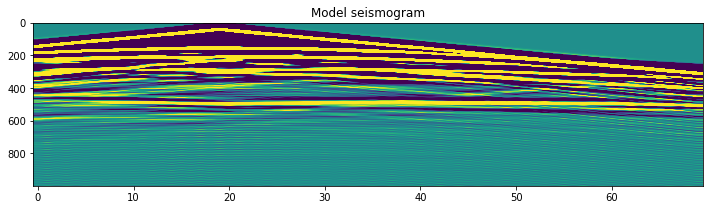

In [13]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram')

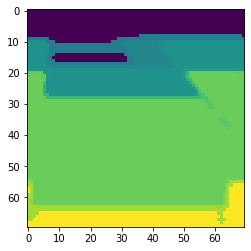

In [14]:
plt.imshow(mat)

In [15]:
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/georec_test/')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/georec_test/')

0

In [16]:
#plot=True
# Load the true model
min1 = []
max1 = []
for kk in range(100,150):
    #kk=2
    #filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/vmodel_test/vmodel'+str(kk)+'.mat'
    filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/vmodel_train/vmodel'+str(kk)+'.mat'
    mat=scipy.io.loadmat(filename)['vmodel']
    mat[np.arange(len(mat)), mat.argmin(axis=1)] = 2000
    mat=resize(mat,(101,101))
    #mat=mat[:-1,:-1]
    #mat = np.loadtxt('marmhard2.dat')
    #mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
    #RB Get model size
    ny = np.size(mat,1);
    nz = np.size(mat,0);
    #RB compute true model mean value and width for future model normalization
    max=np.max(mat)
    min=np.min(mat)
    med=(max+min)/2.
    wid=(max-min)/2.

    print('vmin=',min,'vmax=',max,'vmed=',med,'vwidth=',wid)
    torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
    GPU_string='cuda:'+str(GPU)
    device = torch.device(GPU_string)
    num_dims = 2
    #num_shots = 32
    num_sources_per_shot = 1
    #num_receivers_per_shot = 200

    #RB source_spacing = 25.0
    #RB receiver_spacing = 10.0
    source_spacing = ny * dx / num_shots
    receiver_spacing = ny * dx / num_receivers_per_shot
    print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
    print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
          'ds=',source_spacing,'dr=',receiver_spacing)
    
    # Create arrays containing the source and receiver locations
    # x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
    # x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
    x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
    x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
    #x_s[:, 0, 0] = 100. #RB Set source depth

    x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
    x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
    x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

    #RB Shuffle shot coordinates
    ###idx = torch.randperm(num_shots)
    ###x_s = x_s.view(-1,2)[idx].view(x_s.size())

    #RB Set Receiver depth
    #x_r[0, :, 0] = 100.
    #x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

    # Create true source amplitudes [nt, num_shots, num_sources_per_shot]
    # I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
    # can use whatever Tensor you want as the source amplitude.
    source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                              .reshape(-1, 1, 1)
                              .repeat(1, num_shots, num_sources_per_shot))
    
    model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
    prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
    receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                    x_s.to(device),
                                    x_r.to(device), dt).cpu()
    
    vel=np.squeeze(mat)
    seis=np.squeeze(receiver_amplitudes_all.cpu().detach().numpy())
    seis = seis.swapaxes(1,2)
    mdic = {"Rec":seis}
    
    print(np.shape(seis))
    file1 = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/georec_test/georec'+str(kk)+'.mat','wb')
    savemat(file1, mdic)
    file1.close()
    #file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainA/'+str(kk)+'.npy','wb')
    #np.save(file1,seis)
    #file1.close()
    
    min1 = np.append(min1,np.min(vel))
    max1 = np.append(max1,np.max(vel))

vmin= 2262.2223531539616 vmax= 4500.0 vmed= 3381.111176576981 vwidth= 1118.8888234230192
ny= 101 nz= 101 nt= 1000 dx= 15 freq= 25
shots= 8 recs/shot= 70 ds= 189.375 dr= 21.642857142857142
(1000, 70, 8)
vmin= 2270.7622966345516 vmax= 4500.0 vmed= 3385.381148317276 vwidth= 1114.6188516827242
ny= 101 nz= 101 nt= 1000 dx= 15 freq= 25
shots= 8 recs/shot= 70 ds= 189.375 dr= 21.642857142857142
(1000, 70, 8)
vmin= 2135.0535380394313 vmax= 4500.0 vmed= 3317.5267690197156 vwidth= 1182.4732309802844
ny= 101 nz= 101 nt= 1000 dx= 15 freq= 25
shots= 8 recs/shot= 70 ds= 189.375 dr= 21.642857142857142
(1000, 70, 8)
vmin= 2271.5008706699437 vmax= 4500.0 vmed= 3385.750435334972 vwidth= 1114.2495646650282
ny= 101 nz= 101 nt= 1000 dx= 15 freq= 25
shots= 8 recs/shot= 70 ds= 189.375 dr= 21.642857142857142
(1000, 70, 8)
vmin= 2527.8415480623958 vmax= 4500.0 vmed= 3513.9207740311977 vwidth= 986.0792259688021
ny= 101 nz= 101 nt= 1000 dx= 15 freq= 25
shots= 8 recs/shot= 70 ds= 189.375 dr= 21.642857142857142
(10

(1000, 70, 8)
vmin= 2613.726615988428 vmax= 4500.0 vmed= 3556.8633079942138 vwidth= 943.136692005786
ny= 101 nz= 101 nt= 1000 dx= 15 freq= 25
shots= 8 recs/shot= 70 ds= 189.375 dr= 21.642857142857142
(1000, 70, 8)
vmin= 2139.196314258328 vmax= 4500.0 vmed= 3319.598157129164 vwidth= 1180.401842870836
ny= 101 nz= 101 nt= 1000 dx= 15 freq= 25
shots= 8 recs/shot= 70 ds= 189.375 dr= 21.642857142857142
(1000, 70, 8)
vmin= 2086.2764789759676 vmax= 4500.0 vmed= 3293.138239487984 vwidth= 1206.8617605120162
ny= 101 nz= 101 nt= 1000 dx= 15 freq= 25
shots= 8 recs/shot= 70 ds= 189.375 dr= 21.642857142857142
(1000, 70, 8)
vmin= 2080.416285719711 vmax= 4500.0 vmed= 3290.208142859856 vwidth= 1209.7918571401444
ny= 101 nz= 101 nt= 1000 dx= 15 freq= 25
shots= 8 recs/shot= 70 ds= 189.375 dr= 21.642857142857142
(1000, 70, 8)
vmin= 2140.764510808775 vmax= 4500.0 vmed= 3320.3822554043873 vwidth= 1179.6177445956125
ny= 101 nz= 101 nt= 1000 dx= 15 freq= 25
shots= 8 recs/shot= 70 ds= 189.375 dr= 21.64285714285

In [17]:
np.shape(seis)

(1000, 70, 8)

In [36]:
print(np.min(min1))

2003.341538981923


In [37]:
print(np.max(max1))

4500.0


In [38]:
np.max(VelK)

NameError: name 'VelK' is not defined

In [ ]:
f1 = np.load('/glb/data/eptr_am_2/Arnab/seismogram/trainB/'+str(1)+'.npy')
f1 = np.load('/glb/data/eptr_am_2/Arnab/seismogram/trainB/'+str(1)+'.npy')
np.shape(f1)

In [ ]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat,vmin=min,vmax=max, aspect=1)
    plt.title('True model')
    plt.colorbar()

In [ ]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [ ]:
# Set parameters
##freq = 14
##dx = 10
##dt = 0.001

#RB nt = int(2 / dt) # 2s
#nt = int(0.9 * int(np.sqrt((nz*dx)**2 + (ny*dx)**2) / 2000 / dt))
#nt =       3 * int(np.sqrt((nz*dx)**2 + (ny*dx)**2) / 2000 / dt)
##nt = 4001

num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)


In [ ]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
#x_s[:, 0, 0] = 100. #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [ ]:
model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

In [ ]:
receiver_amplitudes_all.shape

In [ ]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram')

In [ ]:
vel=mat
seis=receiver_amplitudes_all.cpu().detach().numpy()
file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainvel/'+str(kk)+'.npy','wb')
np.save(file1,vel)
file1.close()
file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainseis/'+str(kk)+'.npy','wb')
np.save(file1,seis)
file1.close()

In [ ]:
np.shape(seis)

In [ ]:
np.shape(vel)